In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand

# Q1) Show that when correctly viewed, these triples lie along a set of planes (I get about 30) and so are very much not randomly distributed in space. Do you see the same thing happen with python's random number generator? If possible, can you see the same effect on your local machine? 

In [30]:
# Load in 'random' data

x,y,z = np.loadtxt('rand_points.txt').T

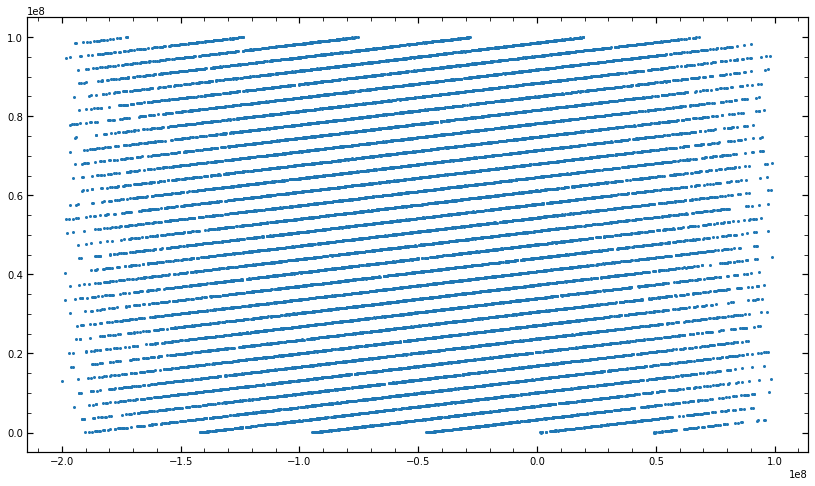

In [34]:
a = -2
b = 1
fig, ax = plt.subplots(figsize=[14,8])
ax.plot(a*x+b*y, z, '.', markersize=4.0);

After setting $a=-2$, $b=1$ and plotting $z$ against $ax+by$, a very obvious pattern was produced similar to the series of planes described in the question.

Now I will test this on my local machine, and see if I can reproduce a similar pattern.

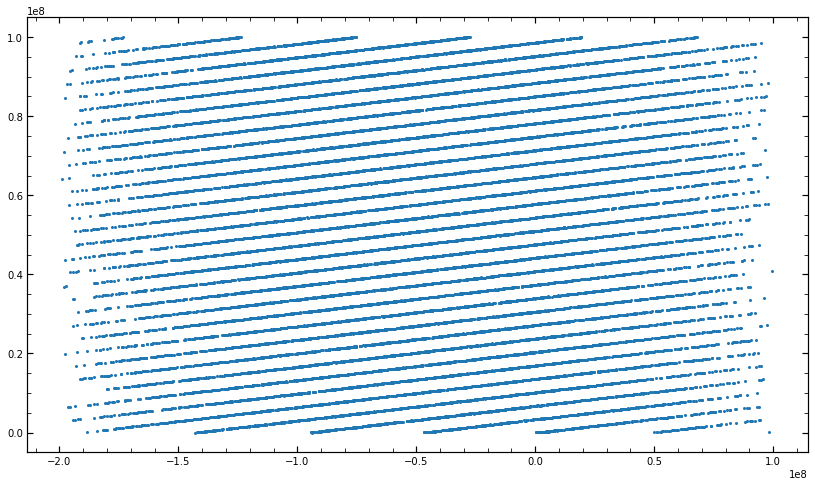

In [44]:
x1,y1,z1 = np.loadtxt('rand_points_local.txt').T
a = -2
b = 1
fig, ax = plt.subplots(figsize=[14,8])
ax.plot(a*x1+b*y1, z1, '.', markersize=4.0);

The same plane-pattern is observed. Now using the random number generator from Python, we can see if the same effect is produced. I used the same code from the `test_broken_libc.py` script, although modified it to use the RNG from the Python `random` module.

In [42]:
def get_rands(num,lower=0,upper=2**31):
    rands = np.zeros(num)
    for i in range(num):
        rands[i] = rand.randint(lower,upper)
    return rands

n=10000
vec=get_rands(n*3)
vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

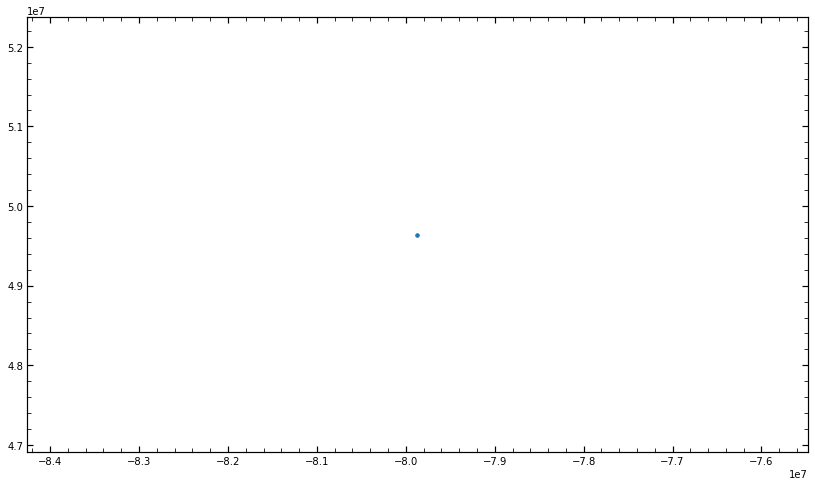

In [50]:
x2,y2,z2 = vv2.T
a = -2
b = 1
fig, ax = plt.subplots(figsize=[14,8])
ax.plot(a*x2+b*y2, z2, '.', markersize=7.0);

There does not appear to be any pattern/structure to the random numbers, indicating that they are in fact random.